## Gradients

$\pi$


$\pi$

cs231n.github.io/neural-networks-3/


In [1]:
from math import sin, cos
import matplotlib.pyplot as plt
import numpy as np

In [2]:
@np.vectorize
def any_function(x):
    return (x)**2 + 3*sin(x) - 4*cos((x)**2)

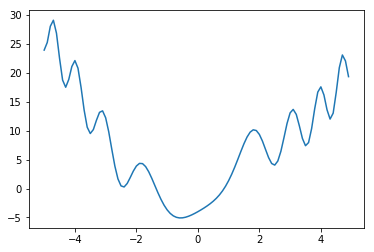

In [3]:
x = np.arange(-5, 5, 0.1)
y = any_function(x)

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.show()

Next, we need to find the deviation. A very simple and popular method is using [finite differences](https://en.wikipedia.org/wiki/Numerical_differentiation).

In [4]:
@np.vectorize
def numerical_derivative(x, f, h = 0.001):
    return (f(x+h) - f(x-h))/(2.0*h)

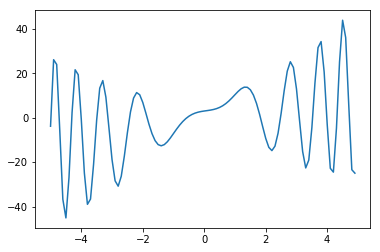

In [5]:
ytick = numerical_derivative(x, any_function)

plt.plot(x,ytick)
plt.show()

Now, we look for an $x$ for which $f'(x) = 0$. Seems like a difficult function to optimize since there are many values where this is the case.

For starters we can choose one point randomly, say $x = 3$, and start our gradient descend - basically we move $x$ to the negative gradient, only scaled by some 'rate' = $\mu$, i.e. $x_{\mathtt{new}} = x_{\mathtt{old}} - \mu * f'(x_{\mathtt{old}})$

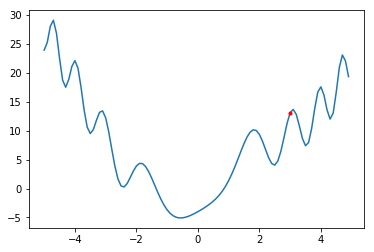

In [50]:
xn = 3
mu = 0.2

plt.plot(x,y)
plt.plot(xn, any_function(xn), '.r')
plt.show()

xn: 0, f(xn) = -5, f'(xn) = 0x
mu = 0x


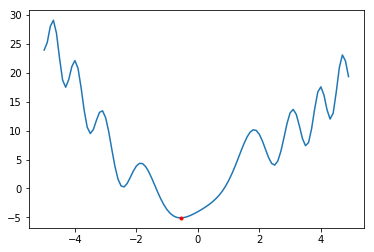

[ -5.00000000e+00  -4.90000000e+00  -4.80000000e+00  -4.70000000e+00
  -4.60000000e+00  -4.50000000e+00  -4.40000000e+00  -4.30000000e+00
  -4.20000000e+00  -4.10000000e+00  -4.00000000e+00  -3.90000000e+00
  -3.80000000e+00  -3.70000000e+00  -3.60000000e+00  -3.50000000e+00
  -3.40000000e+00  -3.30000000e+00  -3.20000000e+00  -3.10000000e+00
  -3.00000000e+00  -2.90000000e+00  -2.80000000e+00  -2.70000000e+00
  -2.60000000e+00  -2.50000000e+00  -2.40000000e+00  -2.30000000e+00
  -2.20000000e+00  -2.10000000e+00  -2.00000000e+00  -1.90000000e+00
  -1.80000000e+00  -1.70000000e+00  -1.60000000e+00  -1.50000000e+00
  -1.40000000e+00  -1.30000000e+00  -1.20000000e+00  -1.10000000e+00
  -1.00000000e+00  -9.00000000e-01  -8.00000000e-01  -7.00000000e-01
  -6.00000000e-01  -5.00000000e-01  -4.00000000e-01  -3.00000000e-01
  -2.00000000e-01  -1.00000000e-01  -1.77635684e-14   1.00000000e-01
   2.00000000e-01   3.00000000e-01   4.00000000e-01   5.00000000e-01
   6.00000000e-01   7.00000000e-01

In [92]:
mu = 0.9*mu
xn = xn - mu * numerical_derivative(xn, any_function)

print 'xn: %d, f(xn) = %d, f\'(xn) = %dx' % (xn, any_function(xn), numerical_derivative(xn, any_function))
print 'mu = %dx' % (mu)
plt.plot(x,y)
plt.plot(xn, any_function(xn), '.r')
plt.show()

## Linear Regression Example

A simple Linear Regression based on Least Squares is usually solved by  $\mathbf{w} = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\hat{y}$ - i.e. it requires (relatively) expensive operation like matrix multiplication and matrix inverse. Sometimes the data is large and using linear algebra is simply not possible.

Gradiens come to help! By using Gradient Descent on the Squared Loss $E = \frac{1}{2}\sum\limits_{\mathbf{x}_i \in \mathbf{X}} (f(\mathbf{x}_i) - y)^2$ we may be able to find hopefully the right weights. 

The derivative of $E$ with respect to a 'weight' $w_i$ in $f(\cdot)$ is $ E'_{w_i} = \frac{dE}{dw_i}$


## Notes

An alternative approach is to comptue the gradient using [Automatic Differentiation](https://pypi.python.org/pypi/ad)